In [1]:
import pandas as pd
import sqlite3
from google.colab import files
import io

# Upload the CSV file
uploaded = files.upload()

# Get the filename from the uploaded files
filename = list(uploaded.keys())[0]

# Load the CSV
df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))

# Create the database file
conn = sqlite3.connect("my_onboarding.db")

# Save it into SQLite
df.to_sql("onboarding_data", conn, if_exists="replace", index=False)

print(f"Successfully loaded {filename} into the database 'my_onboarding.db'")



Saving saas_onboarding_funnel_dataset.csv to saas_onboarding_funnel_dataset.csv
Successfully loaded saas_onboarding_funnel_dataset.csv into the database 'my_onboarding.db'


##Drop-Off Query

In [23]:
query = """
SELECT
    step_name,
    COUNT(*) AS total_users_in_step,
    SUM(CASE WHEN step_completed = 1 THEN 1 ELSE 0 END) AS completed_users,
    ROUND(100.0 * SUM(CASE WHEN step_completed = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS completion_rate_pct
FROM onboarding_data
GROUP BY step_name
ORDER BY completion_rate_pct DESC;
"""

df_funnel = pd.read_sql_query(query, conn)
df_funnel


,step_name,total_users_in_step,completed_users,completion_rate_pct
0,Email Confirmed,300,272,90.67
1,Add Profile Info,272,219,80.51
2,Connect Payment Method,219,147,67.12
3,Invite Team Member,147,89,60.54
4,Complete Setup Tutorial,89,38,42.70


###Drop off by plan type

In [24]:
query = """
SELECT
    plan_type,
    step_name,
    COUNT(*) AS total_users_in_step,
    SUM(CASE WHEN step_completed = 1 THEN 1 ELSE 0 END) AS completed_users,
    ROUND(100.0 * SUM(CASE WHEN step_completed = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS completion_rate_pct
FROM onboarding_data
GROUP BY plan_type, step_name
ORDER BY plan_type, completion_rate_pct DESC;
"""

df_plan = pd.read_sql_query(query, conn)
df_plan

,plan_type,step_name,total_users_in_step,completed_users,completion_rate_pct
0,free,Email Confirmed,96,87,90.63
1,free,Add Profile Info,92,77,83.70
2,free,Connect Payment Method,66,50,75.76
3,free,Invite Team Member,53,30,56.60
4,free,Complete Setup Tutorial,21,9,42.86
5,paid,Email Confirmed,96,86,89.58
6,paid,Add Profile Info,89,74,83.15
7,paid,Connect Payment Method,79,49,62.03
8,paid,Invite Team Member,48,29,60.42
9,paid,Complete Setup Tutorial,34,15,44.12


 Insights & Hypotheses:
 1. Trial users are the flakiest
 2. Paid users struggle at payment method
 3. Free users churn slowly but surely

### Time Between Steps

In [4]:
df.columns

Index(['user_id', 'signup_date', 'step_name', 'step_completed', 'timestamp',
       'cohort_week', 'plan_type'],
      dtype='object')

### Calculate Time Between Steps (Per User)

In [25]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by user and time
df_sorted = df.sort_values(by=['user_id', 'timestamp'])
df_sorted.head()

,user_id,signup_date,step_name,step_completed,timestamp,cohort_week,plan_type
0,1001,2025-06-21,Email Confirmed,True,2025-06-21 00:10:00,2025-06-16,free
1,1001,2025-06-21,Add Profile Info,True,2025-06-21 00:15:00,2025-06-16,paid
2,1001,2025-06-21,Connect Payment Method,False,NaT,2025-06-16,paid
3,1002,2025-06-03,Email Confirmed,True,2025-06-03 00:03:00,2025-06-02,free
4,1002,2025-06-03,Add Profile Info,True,2025-06-03 00:12:00,2025-06-02,paid


### Calculate Time Differences Between Steps

In [26]:
# Shift timestamp per user to get previous step's time
df_sorted['prev_timestamp'] = df_sorted.groupby('user_id')['timestamp'].shift(1)

# Calculate time delta
df_sorted['time_between_steps'] = (df_sorted['timestamp'] - df_sorted['prev_timestamp']).dt.total_seconds() / 60  # in minutes

df_sorted.head()


,user_id,signup_date,step_name,step_completed,timestamp,cohort_week,plan_type,prev_timestamp,time_between_steps
0,1001,2025-06-21,Email Confirmed,True,2025-06-21 00:10:00,2025-06-16,free,NaT,NaN
1,1001,2025-06-21,Add Profile Info,True,2025-06-21 00:15:00,2025-06-16,paid,2025-06-21 00:10:00,5.0
2,1001,2025-06-21,Connect Payment Method,False,NaT,2025-06-16,paid,2025-06-21 00:15:00,NaN
3,1002,2025-06-03,Email Confirmed,True,2025-06-03 00:03:00,2025-06-02,free,NaT,NaN
4,1002,2025-06-03,Add Profile Info,True,2025-06-03 00:12:00,2025-06-02,paid,2025-06-03 00:03:00,9.0


### Analyze Average Time Between Steps


In [27]:
# Drop rows where there's no previous timestamp (i.e., first step)
df_time_diff = df_sorted.dropna(subset=['time_between_steps'])

# Average time between each step (all users combined)
avg_time = df_time_diff.groupby('step_name')['time_between_steps'].mean().round(2).reset_index()
avg_time = avg_time.sort_values(by='time_between_steps', ascending=False)
avg_time


,step_name,time_between_steps
3,Invite Team Member,11.61
2,Connect Payment Method,11.40
0,Add Profile Info,10.98
1,Complete Setup Tutorial,10.29


### By Plan Type

In [28]:
avg_time_by_plan = df_time_diff.groupby(['plan_type', 'step_name'])['time_between_steps'].mean().round(2).reset_index()
avg_time_by_plan.sort_values(by='time_between_steps', ascending=False)

,plan_type,step_name,time_between_steps
7,paid,Invite Team Member,12.14
11,trial,Invite Team Member,11.93
10,trial,Connect Payment Method,11.79
5,paid,Complete Setup Tutorial,11.47
2,free,Connect Payment Method,11.46
8,trial,Add Profile Info,11.01
0,free,Add Profile Info,10.96
4,paid,Add Profile Info,10.96
6,paid,Connect Payment Method,10.96
3,free,Invite Team Member,10.77


###Interactive Filter by Plan Type

In [9]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00


In [30]:
import ipywidgets as widgets
# Get unique plan types
plan_types = df['plan_type'].unique().tolist()

# Define two separate dropdowns
plan_dropdown_funnel = widgets.Dropdown(options=plan_types, description='Plan Type:')
plan_dropdown_chart = widgets.Dropdown(options=plan_types, description='Plan Type:')


### Funnel Table (Static View for GitHub)

Below is a static view of the funnel data, showing the results for the 'free' plan type. The interactive filtering has been removed to ensure compatibility with GitHub rendering.

In [44]:
# Static view for 'free' plan type
plan_type_static = 'free'

df_filtered_static = df[df['plan_type'] == plan_type_static]

# Recalculate funnel
funnel_static = (
    df_filtered_static.groupby('step_name')
    .agg(total_users=('user_id', 'count'),
         completed_users=('step_completed', 'sum'))
    .reset_index()
)

funnel_static['completion_rate_pct'] = round(100 * funnel_static['completed_users'] / funnel_static['total_users'], 2)
funnel_static = funnel_static.sort_values('completion_rate_pct', ascending=False)

print(f"\n Onboarding Funnel for '{plan_type_static}' Users:\n")
display(funnel_static)


 Onboarding Funnel for 'free' Users:



,step_name,total_users,completed_users,completion_rate_pct
3,Email Confirmed,96,87,90.62
0,Add Profile Info,92,77,83.70
2,Connect Payment Method,66,50,75.76
4,Invite Team Member,53,30,56.60
1,Complete Setup Tutorial,21,9,42.86


### Time Between Steps (Static View for GitHub)

Below is a static view of the average time between steps, showing the results for the 'free' plan type. The interactive filtering has been removed to ensure compatibility with GitHub rendering.

In [45]:
# Static view for 'free' plan type
plan_type_static = 'free'

df_plan_static = df_sorted[df_sorted['plan_type'] == plan_type_static].copy()
df_plan_static['prev_timestamp'] = df_plan_static.groupby('user_id')['timestamp'].shift(1)
df_plan_static['time_between_steps'] = (df_plan_static['timestamp'] - df_plan_static['prev_timestamp']).dt.total_seconds() / 60
df_plan_static = df_plan_static.dropna(subset=['time_between_steps'])

avg_delay_static = (
    df_plan_static.groupby('step_name')
    ['time_between_steps']
    .mean()
    .round(2)
    .sort_values(ascending=False)
    .reset_index()
)

print(f"\n Average Time Between Steps for '{plan_type_static}' Users:\n")
display(avg_delay_static)


 Average Time Between Steps for 'free' Users:



,step_name,time_between_steps
0,Complete Setup Tutorial,17.62
1,Invite Team Member,17.00
2,Connect Payment Method,11.50


### Funnel Completion Plot (Static View for GitHub)

Below is a static view of the funnel completion plot, showing the results for the 'free' plan type. The interactive filtering has been removed to ensure compatibility with GitHub rendering.

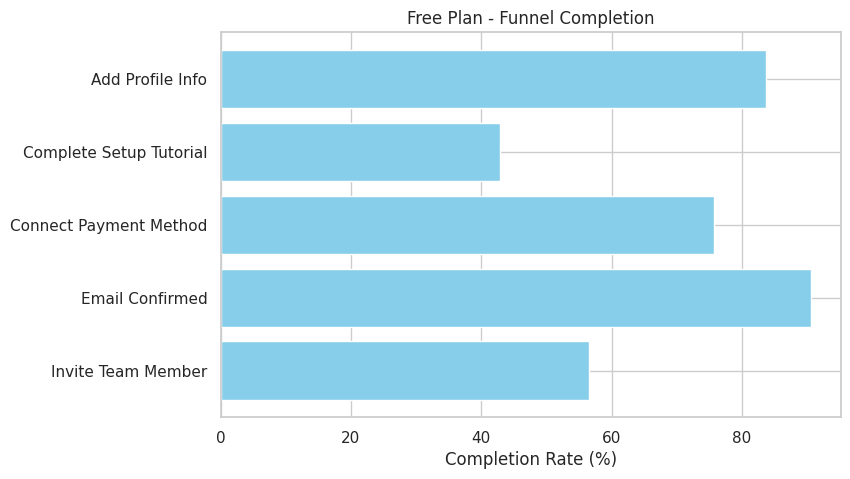

In [46]:
import matplotlib.pyplot as plt

# Static view for 'free' plan type
plan_type_static = 'free'

df_filtered_static = df[df['plan_type'] == plan_type_static]

funnel_static = (
    df_filtered_static.groupby('step_name')
    .agg(total_users=('user_id', 'count'),
         completed_users=('step_completed', 'sum'))
    .reset_index()
)

funnel_static['completion_rate_pct'] = 100 * funnel_static['completed_users'] / funnel_static['total_users']

plt.figure(figsize=(8, 5))
plt.barh(funnel_static['step_name'], funnel_static['completion_rate_pct'], color='skyblue')
plt.xlabel('Completion Rate (%)')
plt.title(f"{plan_type_static.capitalize()} Plan - Funnel Completion")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.show()

### Funnel Completion Bar Chart (Static View for GitHub)

Below is a static view of the funnel completion bar chart, showing the results for the 'free' plan type. The interactive filtering has been removed to ensure compatibility with GitHub rendering.

/tmp/ipython-input-899928136.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=funnel_static, x='completion_rate_pct', y='step_name', palette='Blues_d')
/tmp/ipython-input-899928136.py:36: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


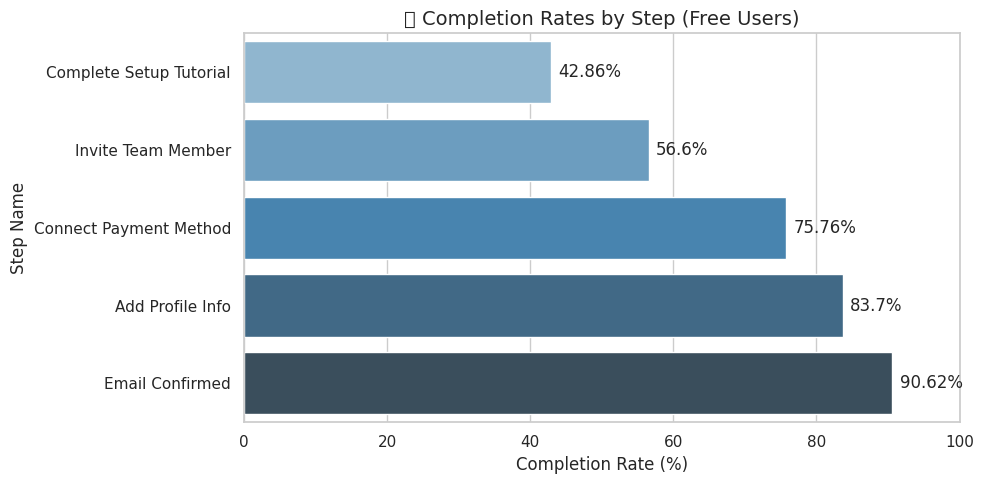

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Static view for 'free' plan type
plan_type_static = 'free'

# Filter and prep data
df_filtered_static = df[df['plan_type'] == plan_type_static]

funnel_static = (
    df_filtered_static.groupby('step_name')
    .agg(total_users=('user_id', 'count'),
         completed_users=('step_completed', 'sum'))
    .reset_index()
)

funnel_static['completion_rate_pct'] = round(100 * funnel_static['completed_users'] / funnel_static['total_users'], 2)
funnel_static = funnel_static.sort_values('completion_rate_pct', ascending=True)  # Ascending for nice horizontal bars

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=funnel_static, x='completion_rate_pct', y='step_name', palette='Blues_d')

plt.title(f"🔍 Completion Rates by Step ({plan_type_static.capitalize()} Users)", fontsize=14)
plt.xlabel("Completion Rate (%)")
plt.ylabel("Step Name")
plt.xlim(0, 100)

# Add value labels
for index, value in enumerate(funnel_static['completion_rate_pct']):
    plt.text(value + 1, index, f"{value}%", va='center')

plt.tight_layout()
plt.show()

##Funnel Summary CSV Export

In [38]:
# Generate funnel summary
funnel_summary = (
    df.groupby(['plan_type', 'step_name'])
    .agg(
        total_users=('user_id', 'count'),
        completed_users=('step_completed', 'sum')
    )
    .reset_index()
)

funnel_summary['completion_rate_pct'] = (
    100 * funnel_summary['completed_users'] / funnel_summary['total_users']
).round(2)

# Save to CSV
funnel_summary.to_csv("funnel_summary.csv", index=False)

print(" Funnel summary exported as 'funnel_summary.csv'")


 Funnel summary exported as 'funnel_summary.csv'


##Time Delay Summary CSV Export

In [39]:
# Make sure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort and compute time between steps
df_sorted = df.sort_values(['user_id', 'timestamp']).copy()
df_sorted['prev_timestamp'] = df_sorted.groupby('user_id')['timestamp'].shift(1)
df_sorted['time_between_steps'] = (df_sorted['timestamp'] - df_sorted['prev_timestamp']).dt.total_seconds() / 60
df_sorted = df_sorted.dropna(subset=['time_between_steps'])

# Group and summarize
delay_summary = (
    df_sorted.groupby(['plan_type', 'step_name'])['time_between_steps']
    .mean()
    .round(2)
    .reset_index()
)

# Save to CSV
delay_summary.to_csv("time_delay_summary.csv", index=False)

print(" Time delay summary exported as 'time_delay_summary.csv'")


 Time delay summary exported as 'time_delay_summary.csv'


In [17]:
from google.colab import files
files.download("funnel_summary.csv")
files.download("time_delay_summary.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>